# Creating search terms for web crawls

We will use species data sets to make list of search terms. In the first instance, this is for use in (Bing) custom web search. But we will also use these for scraping research listings just as <a href="https://www.biorxiv.org/">biorxiv.org</a>, <a href="https://scielo.org/">scielo.org</a>, <a href="https://www.jstage.jst.go.jp/">jstage.jst.go.jp</a>, <a href="https://cnki.net/">cnki.net</a>.

Start with the BirdLife spreadsheet of species:

In [7]:
import pandas as pd

taxfile = "../data/BirdLife_species_list_Jan_2022.xlsx"

tax = pd.read_excel(taxfile, header = 0).fillna('')
new_tax_columns = {
    'Common name': 'comName',
    'Scientific name': 'sciName',
    'Synonyms': 'syn',
    'Alternative common names' : 'alt'
}
tax.rename(columns=new_tax_columns, inplace=True)
tax

,comName,sciName,syn,alt,SISRecID,Unnamed: 5
0,Common Ostrich,Struthio camelus,,,45020636.0,
1,Somali Ostrich,Struthio molybdophanes,,,22732795.0,
2,Greater Rhea,Rhea americana,,"Common Rhea, Avestruz, Ñandú, Ñandú Común",22678073.0,
3,Lesser Rhea,Rhea pennata,,,22728199.0,
4,Puna Rhea,Rhea tarapacensis,,,22728206.0,
...,...,...,...,...,...,...
13133,,Tangara cyanoptera,,,22722950.0,
13134,,Tangara vassorii,,,22722933.0,
13135,,Tangara velia,,,22731274.0,
13136,,Tangara brasiliensis,,,22731781.0,


As a starter list, we construct the generic common names (i.e. 'ostrich' from 'common ostrich'):

In [31]:
from pprint import pprint

com_words = [x.split() for x in tax['comName']]
words_single = list(set([y[0].lower() for y in com_words if len(y) == 1]))
words_generic = list(set([y[-1].lower() for y in com_words if len(y) > 1]))

com_words = sorted(list(set(words_single + words_generic)))
print(f'Total {len(com_words)} words')
pprint(com_words[:10])
print('...')
pprint(com_words[-10:])

Total 1048 words
['accentor',
 'adjutant',
 'akalat',
 'akekee',
 'akepa',
 'akialoa',
 'akiapolaau',
 'akikiki',
 'akohekohe',
 'alauahio']
...
['xenops',
 'yellow-finch',
 'yellowbill',
 'yellowbrow',
 'yellowhammer',
 'yellowhead',
 'yellowlegs',
 'yellownape',
 'yellowthroat',
 'yuhina']


We could add the same construction for the field 'alt', capturing alternative names. The reason we don't is that these are often non-English, e.g. French, with reverse word order, so the position of the generic name is unpredictable.

In [29]:
import random
from pprint import pprint

alt_names = [x.split(',') for x in tax['alt']]
alt_names = [x for x in alt_names if x != ['']]
alt_names = [x.strip() for x in sum(alt_names, [])]

pprint(random.sample(alt_names, 10))

['Souimanga à tête bleue',
 'Buff-cheeked Tody-Flycatcher',
 'Tawny-bellied Screech Owl',
 'Pingüino patagónico',
 'Orange-crowned Fairywren',
 'Faisán de Cola Ocelada Malayo',
 'Miniature Tit-babbler',
 'Veuve à épaulettes orangées',
 'Red-tailed Bulbul',
 'African Olive Pigeon']


Our approach for custom web search will be to combine the generic 'English' common names with generic scientific (Latin) name.

In [41]:
sci_words = [x.split() for x in tax['sciName']]
sci_words = list(set([y[0].lower() for y in sci_words if len(y) > 0]))

sci_words = sorted(sci_words)
print(f'Total {len(sci_words)} words')
pprint(sci_words[:10])
print('...')
pprint(sci_words[-10:])

Total 2400 words
['abeillia',
 'abroscopus',
 'aburria',
 'acanthagenys',
 'acanthidops',
 'acanthis',
 'acanthisitta',
 'acanthiza',
 'acanthoptila',
 'acanthorhynchus']
...
['zeledonia',
 'zenaida',
 'zentrygon',
 'zimmerius',
 'zonerodius',
 'zonotrichia',
 'zoonavena',
 'zoothera',
 'zosterops',
 'zosterornis']


This is our general list of search terms, which we write to disk for use by the custom search script.

In [46]:
search_terms_general = list(set(com_words + sci_words))
print(f'Total {len(search_terms_general)} search terms')

# write to disk

searchterm_file = "../data/searchterms_general.txt"
    
with open(searchterm_file, 'w') as sf:
    for w in sorted(search_terms_general):
        sf.write(w + '\n')
sf.close()

Total 3363 search terms


## Targeting vulnerable species

For research content servers, we will use a narrower set of search terms in order to target species with red-list status higher than <i>LC</i> (and also not <i>EX</i>). Also, in order to be language-agnostic, we will use only the scientific genus names.

For this, we will use the data set of 11,107 species created by scraping BirdLife DataZone:

In [48]:
import pandas as pd

blifile = "../data/master-BLI-11107.csv"

bli = pd.read_csv(blifile, header = 0).fillna('')
bli = bli[['name_sci','status']]
bli

,name_sci,status
0,Heleia superciliaris,LC
1,Oriturus superciliosus,LC
2,Schistolais leucopogon,LC
3,Fluvicola nengeta,LC
4,Sylvietta chapini,CR
...,...,...
11102,Tangara inornata,LC
11103,Tangara mexicana,LC
11104,Tangara chilensis,LC
11105,Tangara callophrys,LC


Check the status distribution:

In [56]:
from collections import Counter
from pprint import pprint

pprint( Counter(bli['status']) )

# check anomalous rows:
bli[bli['status'] == '']

Counter({'LC': 8459,
         'NT': 1004,
         'VU': 768,
         'EN': 444,
         'CR': 197,
         'EX': 157,
         'DD': 50,
         'PE': 22,
         'EW': 5,
         '': 1})


,name_sci,status
4418,Acanthidops bairdi,


Let's record, for each genus name as in the previous section, two counts: how many species it covers with status <i>LC</i> or <i>EX</i>, and how many species with other status values.

In [109]:
lc_count = dict()
vu_count = dict()

for i in range(bli.shape[0]):
    name = bli.at[i, 'name_sci']
    genus = name.split()[0].lower()
    if genus not in lc_count:
        lc_count[genus] = 0
    if genus not in vu_count:
        vu_count[genus] = 0
    status = bli.at[i, 'status']
    if status in ['LC','EX']:
        lc_count[genus] += 1
    else:
        vu_count[genus] += 1
        
print(f'Total genus names {len(lc_count.keys())}')
print(f'Total LC genera {len( [g for g in lc_count if lc_count[g] > 0] )}')
print(f'Total VU genera {len( [g for g in lc_count if vu_count[g] > 0] )}')

Total genus names 2372
Total LC genera 2092
Total VU genera 1017


Note that this data set has 2,372 genus names – 28 fewer than the 2,400 we found above in the BLI spreadsheet.

Let's plot the two counts:

<function matplotlib.pyplot.show(close=None, block=None)>

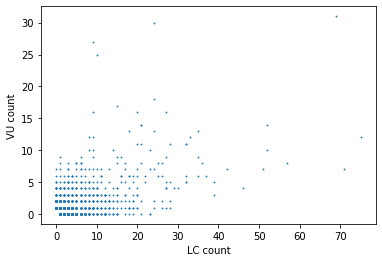

In [80]:
from matplotlib import pyplot as plt

genus = sorted(lc_count.keys())
x = [lc_count[g] for g in genus]
y = [vu_count[g] for g in genus]

plt.scatter(x,y, s = 0.7)
plt.xlabel('LC count')
plt.ylabel('VU count')
plt.show

Make a data frame and write to disk:

In [104]:
search_terms_restricted = pd.DataFrame({
    'genus':lc_count.keys(), 
    'lc_count': lc_count.values(), 
    'vu_count': vu_count.values()}
).sort_values(by = 'genus')

searchterm_file = "../data/searchterms_restricted.txt"
search_terms_restricted.to_csv(searchterm_file, index = False)

search_terms_restricted

,genus,lc_count,vu_count
1299,abeillia,1,0
60,abroscopus,3,0
1816,aburria,0,1
860,acanthagenys,1,0
1561,acanthidops,0,1
...,...,...,...
524,zonotrichia,4,1
207,zoonavena,3,0
232,zoothera,13,7
184,zosterops,69,31


The proposal is that for search in <a href="https://www.biorxiv.org/">biorxiv.org</a>, <a href="https://scielo.org/">scielo.org</a>, <a href="https://www.jstage.jst.go.jp/">jstage.jst.go.jp</a>, <a href="https://cnki.net/">cnki.net</a> etc we use the 1,017 geneus names with nonzero 'vu_count'.